# Import Necessary Packages and Libraries

In [1]:
# IMAGE PREPROCESSING FUNCTIONS FOR USE IN MODEL DEVELOPMENT, EVALUATION, AND PRODUCTION
import numpy as np
import pandas as pd
import PIL as pil
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import tempfile
import pickle
import time
import gc
import skimage.filters
import cv2
import watermark
import joblib
import math
from skimage.measure import block_reduce
from image_preprocessing import standardize_image_dataset,resize_dataset,binarize_dataset,crop_dataset,process_dataset_blur,do_pooling_dataset
from pipeline import model_pipeline

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB,CategoricalNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.base import clone
from sklearn.metrics import confusion_matrix

In [2]:
!pip install tensorflow

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def define_model(input_shape, n_classes, n_conv_branches = 1, dropout = 0.2, reg_alpha = 1e-3):
    inputs = layers.Input(shape = input_shape)
    
    b_in = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)
    
    branches = [b_in] * n_conv_branches
    
    for i in range(n_conv_branches):
        for filter_size in [32, 64, 128, 128, 128, 128, 128]:
            branches[i] = layers.Conv2D(
                filters = filter_size,
                kernel_size = 3,
                padding = 'same',
                kernel_regularizer = regularizers.L2(reg_alpha),
                bias_regularizer = regularizers.L2(reg_alpha)
            )(branches[i])
            branches[i] = layers.MaxPool2D(pool_size = (2, 2))(branches[i])
            branches[i] = layers.ReLU()(branches[i])
            branches[i] = layers.Dropout(dropout)(branches[i])
    
    if n_conv_branches > 1:
        b_out = layers.concatenate(branches)
        b_out = layers.Flatten()(b_out)
    else:
        b_out = layers.Flatten()(branches[0])
    
    b_out = layers.Dense(
        units = 128,
        kernel_regularizer = regularizers.L2(reg_alpha),
        bias_regularizer = regularizers.L2(reg_alpha)
    )(b_out)
    b_out = layers.BatchNormalization()(b_out)
    b_out = layers.ReLU()(b_out)
    b_out = layers.Dropout(dropout)(b_out)
    
    outputs = layers.Dense(units = n_classes)(b_out)
    
    return Model(inputs, outputs)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Read in Training Data

In [4]:
all_training_data = pickle.load(open('../../w207_final_project/Amit/Labeled Data/train_data.pkl','rb'))
train_X = all_training_data.iloc[:,:-1]
train_y = all_training_data.iloc[:,-1]
del all_training_data
gc.collect()

22

In [5]:
#Initial Size
print(train_X.shape)
print(train_y.shape)

(3220, 65536)
(3220,)


In [6]:
train_X.shape[1]

65536

In [7]:
train_X_array = train_X.to_numpy().reshape(3220, 256, 256)

In [8]:
print(train_X_array.shape[0], train_X_array.shape[1], train_X_array.shape[2]) 

3220 256 256


In [9]:
type(train_y)

pandas.core.series.Series

In [10]:
train_y_array = np.array(train_y)

In [11]:
type(train_y_array)

numpy.ndarray

In [12]:
import tensorflow as tf

In [13]:
tf.__version__

'2.6.2'

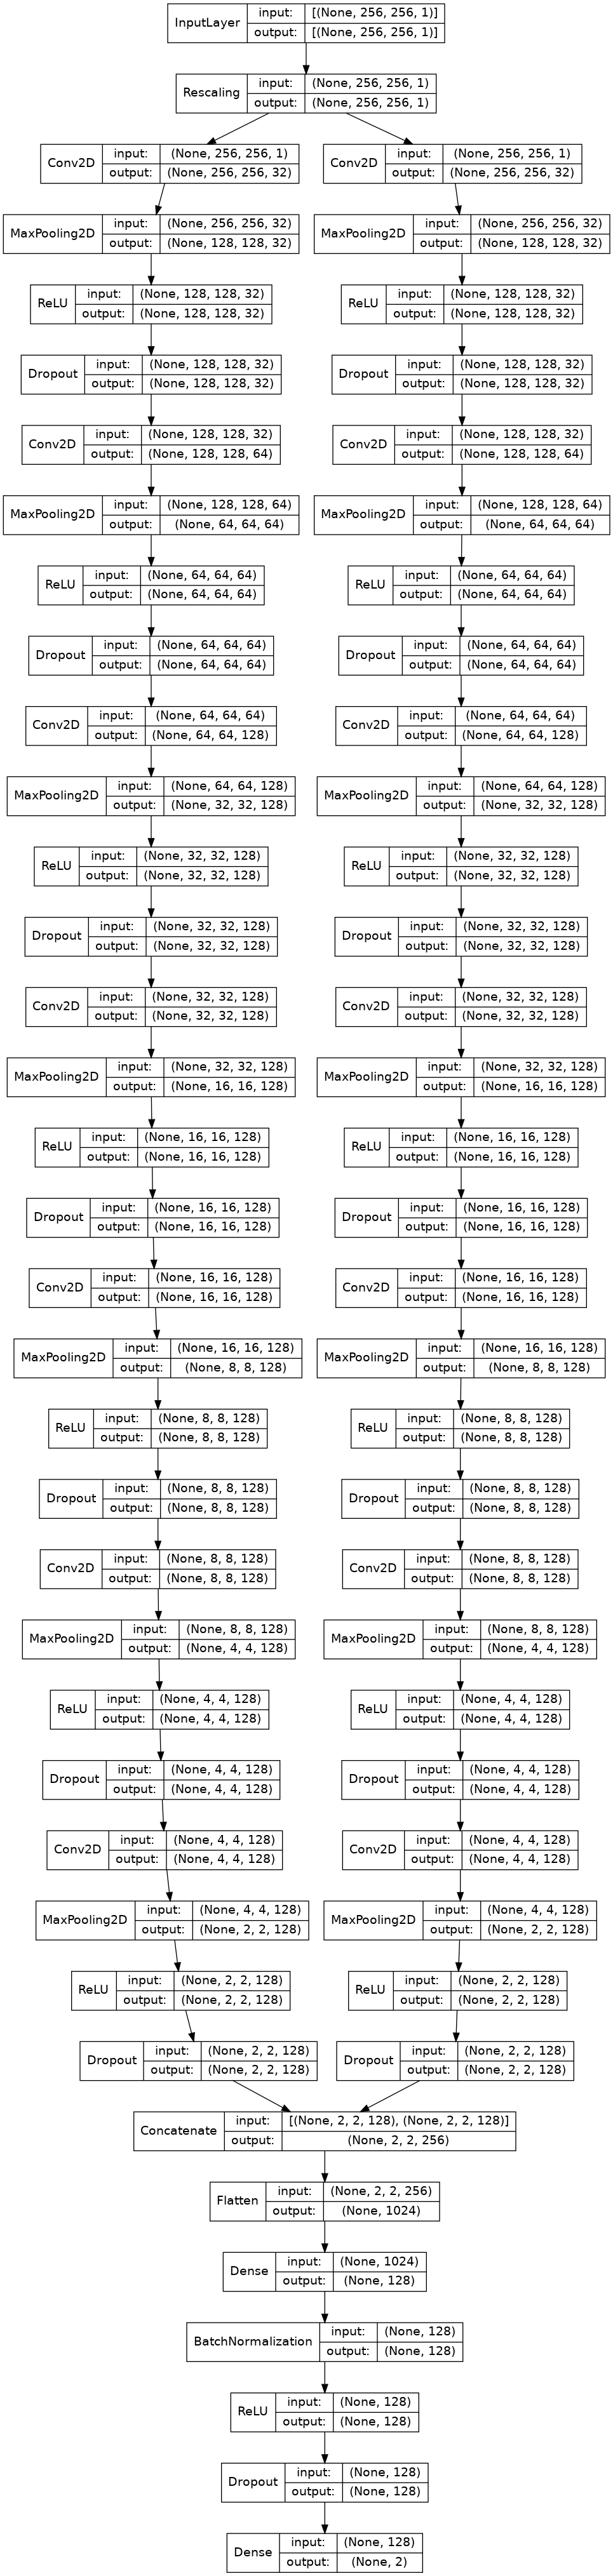

In [14]:
model = define_model(
    (train_X_array.shape[1], train_X_array.shape[2], 1),
    2,
    2,
    0.2,
    1e-3
)

tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = False)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
CHECKPOINT_DIR = './checkpoint'

cv = StratifiedKFold(n_splits = N_SPLITS, random_state = 42, shuffle = True)

cv_val_scores = np.zeros(N_SPLITS)
histories = []

k = 0

for train_i, val_i in cv.split(train_X_array, train_y_array):
    x_train = train_X_array[train_i, :]
    x_valid = train_X_array[val_i, :]
    
    y_train = train_y_array[train_i]
    y_valid = train_y_array[val_i]
    
    gc.collect()
    
    optimizer = Adam(
        learning_rate = 5e-4,
    )
    
    model = define_model(
        (train_X_array.shape[1], train_X_array.shape[2], 1),
        2,
        2,
        0.2,
        1e-3
    )
    
    model.compile(
        optimizer = optimizer,
        loss = SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy']
    )
    
    checkpoint_call = ModelCheckpoint(
        filepath = CHECKPOINT_DIR,
        save_weights_only = True,
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only = True
    )
    
    stopping_call = EarlyStopping(
        monitor = 'val_accuracy',
        patience = 50,
        mode = 'max'
    )
    
    history = model.fit(
        x_train, y_train,
        validation_data = (x_valid, y_valid),
        epochs = 200,
        callbacks = [checkpoint_call, stopping_call],
        batch_size = 64,
    )
    
    histories += [history]
    
    model.load_weights(CHECKPOINT_DIR)
    predictor_model = tf.keras.Sequential([model, layers.Softmax()])
    
    cv_val_scores[k] = model.evaluate(x_valid, y_valid)[1]
    
    k += 1

Epoch 1/200
46/46 [==============================] - 121s 3s/step - loss: 2.2214 - accuracy: 0.5749 - val_loss: 2.0524 - val_accuracy: 0.5435
Epoch 2/200
46/46 [==============================] - 119s 3s/step - loss: 1.9748 - accuracy: 0.6139 - val_loss: 1.9157 - val_accuracy: 0.5683
Epoch 3/200
46/46 [==============================] - 119s 3s/step - loss: 1.7427 - accuracy: 0.6708 - val_loss: 1.7160 - val_accuracy: 0.5901
Epoch 4/200
46/46 [==============================] - 119s 3s/step - loss: 1.5680 - accuracy: 0.7150 - val_loss: 1.8837 - val_accuracy: 0.5621
Epoch 5/200
46/46 [==============================] - 119s 3s/step - loss: 1.4048 - accuracy: 0.7581 - val_loss: 1.8715 - val_accuracy: 0.5528
Epoch 6/200
46/46 [==============================] - 120s 3s/step - loss: 1.2288 - accuracy: 0.8164 - val_loss: 1.6906 - val_accuracy: 0.5683
Epoch 7/200
46/46 [==============================] - 121s 3s/step - loss: 1.0921 - accuracy: 0.8537 - val_loss: 1.9190 - val_accuracy: 0.5528
Epoch 

In [ ]:
print('Validation AUC: {:.6} ± {:.4}'.format(cv_val_scores.mean(), cv_val_scores.std()))

In [ ]:
histories

In [ ]:
len(histories)

In [ ]:
pickle.dump(histories,open('linear_model_results/multilayer_nn.pkl','wb'))